In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 of58uq12


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-of58uq12:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.5


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_rcn = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_rcn = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_rcn = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_rcn = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_rcn = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    emb, lgt, rcn = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                             | 0/659 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                    | 1/659 [00:00<05:34,  1.96it/s]

  1%|██                                                                                                                                                   | 9/659 [00:00<00:34, 18.85it/s]

  3%|███▊                                                                                                                                                | 17/659 [00:00<00:19, 32.82it/s]

  4%|█████▌                                                                                                                                              | 25/659 [00:00<00:14, 44.07it/s]

  5%|███████▍                                                                                                                                            | 33/659 [00:00<00:11, 52.59it/s]

  6%|█████████▏                                                                                                                                          | 41/659 [00:01<00:10, 58.96it/s]

  7%|███████████                                                                                                                                         | 49/659 [00:01<00:09, 63.59it/s]

  9%|████████████▊                                                                                                                                       | 57/659 [00:01<00:08, 67.00it/s]

 10%|██████████████▌                                                                                                                                     | 65/659 [00:01<00:08, 69.53it/s]

 11%|████████████████▍                                                                                                                                   | 73/659 [00:01<00:08, 71.24it/s]

 12%|██████████████████▏                                                                                                                                 | 81/659 [00:01<00:07, 72.46it/s]

 14%|███████████████████▉                                                                                                                                | 89/659 [00:01<00:07, 73.31it/s]

 15%|█████████████████████▊                                                                                                                              | 97/659 [00:01<00:07, 73.89it/s]

 16%|███████████████████████▍                                                                                                                           | 105/659 [00:01<00:07, 74.09it/s]

 17%|█████████████████████████▏                                                                                                                         | 113/659 [00:01<00:07, 74.15it/s]

 18%|██████████████████████████▉                                                                                                                        | 121/659 [00:02<00:07, 74.28it/s]

 20%|████████████████████████████▊                                                                                                                      | 129/659 [00:02<00:07, 74.29it/s]

 21%|██████████████████████████████▌                                                                                                                    | 137/659 [00:02<00:06, 74.67it/s]

 22%|████████████████████████████████▎                                                                                                                  | 145/659 [00:02<00:06, 74.69it/s]

 23%|██████████████████████████████████▏                                                                                                                | 153/659 [00:02<00:06, 74.67it/s]

 24%|███████████████████████████████████▉                                                                                                               | 161/659 [00:02<00:06, 74.89it/s]

 26%|█████████████████████████████████████▋                                                                                                             | 169/659 [00:02<00:06, 75.08it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 177/659 [00:02<00:06, 75.03it/s]

 28%|█████████████████████████████████████████▎                                                                                                         | 185/659 [00:02<00:06, 74.99it/s]

 29%|███████████████████████████████████████████                                                                                                        | 193/659 [00:03<00:06, 75.10it/s]

 31%|████████████████████████████████████████████▊                                                                                                      | 201/659 [00:03<00:06, 75.18it/s]

 32%|██████████████████████████████████████████████▌                                                                                                    | 209/659 [00:03<00:05, 75.30it/s]

 33%|████████████████████████████████████████████████▍                                                                                                  | 217/659 [00:03<00:05, 75.32it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 225/659 [00:03<00:05, 75.31it/s]

 35%|███████████████████████████████████████████████████▉                                                                                               | 233/659 [00:03<00:05, 75.33it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 241/659 [00:03<00:05, 75.36it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 249/659 [00:03<00:05, 75.08it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 257/659 [00:03<00:05, 75.08it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 265/659 [00:04<00:05, 74.72it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 273/659 [00:04<00:05, 74.56it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 281/659 [00:04<00:05, 74.74it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 289/659 [00:04<00:04, 74.74it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 297/659 [00:04<00:04, 75.03it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 305/659 [00:04<00:04, 75.17it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                             | 313/659 [00:04<00:04, 75.27it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 321/659 [00:04<00:04, 75.31it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                         | 329/659 [00:04<00:04, 75.32it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 337/659 [00:04<00:04, 75.38it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 345/659 [00:05<00:04, 75.42it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 353/659 [00:05<00:04, 75.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 361/659 [00:05<00:03, 75.43it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 369/659 [00:05<00:03, 75.45it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 377/659 [00:05<00:03, 75.47it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 385/659 [00:05<00:03, 75.46it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 393/659 [00:05<00:03, 75.35it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 401/659 [00:05<00:03, 75.26it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 409/659 [00:05<00:03, 75.16it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                      | 417/659 [00:06<00:03, 75.10it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 425/659 [00:06<00:03, 75.10it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 433/659 [00:06<00:03, 75.02it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 441/659 [00:06<00:02, 74.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 449/659 [00:06<00:02, 74.98it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 457/659 [00:06<00:02, 75.11it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 465/659 [00:06<00:02, 75.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 473/659 [00:06<00:02, 75.32it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 481/659 [00:06<00:02, 75.37it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 489/659 [00:06<00:02, 75.37it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 497/659 [00:07<00:02, 75.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 505/659 [00:07<00:02, 74.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 513/659 [00:07<00:01, 74.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 521/659 [00:07<00:01, 74.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 529/659 [00:07<00:01, 74.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 537/659 [00:07<00:01, 74.72it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 545/659 [00:07<00:01, 74.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 553/659 [00:07<00:01, 75.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 561/659 [00:07<00:01, 75.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 569/659 [00:08<00:01, 75.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 577/659 [00:08<00:01, 75.34it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 585/659 [00:08<00:00, 75.34it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 593/659 [00:08<00:00, 75.26it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 601/659 [00:08<00:00, 75.00it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 609/659 [00:08<00:00, 74.83it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 617/659 [00:08<00:00, 74.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 625/659 [00:08<00:00, 74.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 633/659 [00:08<00:00, 74.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 641/659 [00:09<00:00, 74.73it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 649/659 [00:09<00:00, 74.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 657/659 [00:09<00:00, 74.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:09<00:00, 70.57it/s]

train - OK


  0%|                                                                                                                                                              | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                    | 1/83 [00:00<00:16,  5.09it/s]

 11%|████████████████▎                                                                                                                                     | 9/83 [00:00<00:02, 35.71it/s]

 20%|██████████████████████████████▌                                                                                                                      | 17/83 [00:00<00:01, 50.96it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 25/83 [00:00<00:00, 59.34it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 33/83 [00:00<00:00, 64.57it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 41/83 [00:00<00:00, 67.78it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 49/83 [00:00<00:00, 69.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 57/83 [00:00<00:00, 71.33it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 65/83 [00:01<00:00, 72.27it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 73/83 [00:01<00:00, 72.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 81/83 [00:01<00:00, 73.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 59.42it/s]

val - OK


  0%|                                                                                                                                                              | 0/83 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                    | 1/83 [00:00<00:17,  4.64it/s]

 11%|████████████████▎                                                                                                                                     | 9/83 [00:00<00:02, 34.08it/s]

 20%|██████████████████████████████▌                                                                                                                      | 17/83 [00:00<00:01, 49.45it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 25/83 [00:00<00:00, 58.68it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 33/83 [00:00<00:00, 64.29it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 41/83 [00:00<00:00, 67.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 49/83 [00:00<00:00, 70.20it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 57/83 [00:00<00:00, 71.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 65/83 [00:01<00:00, 73.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 73/83 [00:01<00:00, 73.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 81/83 [00:01<00:00, 74.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 59.20it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                    | 1/680 [00:00<02:31,  4.49it/s]

  1%|█▉                                                                                                                                                   | 9/680 [00:00<00:20, 33.19it/s]

  2%|███▋                                                                                                                                                | 17/680 [00:00<00:13, 48.56it/s]

  4%|█████▍                                                                                                                                              | 25/680 [00:00<00:11, 57.81it/s]

  5%|███████▏                                                                                                                                            | 33/680 [00:00<00:10, 63.60it/s]

  6%|████████▉                                                                                                                                           | 41/680 [00:00<00:09, 67.37it/s]

  7%|██████████▋                                                                                                                                         | 49/680 [00:00<00:09, 69.80it/s]

  8%|████████████▍                                                                                                                                       | 57/680 [00:00<00:08, 71.61it/s]

 10%|██████████████▏                                                                                                                                     | 65/680 [00:01<00:08, 72.75it/s]

 11%|███████████████▉                                                                                                                                    | 73/680 [00:01<00:08, 73.61it/s]

 12%|█████████████████▋                                                                                                                                  | 81/680 [00:01<00:08, 74.16it/s]

 13%|███████████████████▎                                                                                                                                | 89/680 [00:01<00:07, 74.32it/s]

 14%|█████████████████████                                                                                                                               | 97/680 [00:01<00:07, 74.41it/s]

 15%|██████████████████████▋                                                                                                                            | 105/680 [00:01<00:07, 74.72it/s]

 17%|████████████████████████▍                                                                                                                          | 113/680 [00:01<00:07, 74.84it/s]

 18%|██████████████████████████▏                                                                                                                        | 121/680 [00:01<00:07, 74.96it/s]

 19%|███████████████████████████▉                                                                                                                       | 129/680 [00:01<00:07, 75.11it/s]

 20%|█████████████████████████████▌                                                                                                                     | 137/680 [00:02<00:07, 75.29it/s]

 21%|███████████████████████████████▎                                                                                                                   | 145/680 [00:02<00:07, 75.40it/s]

 22%|█████████████████████████████████                                                                                                                  | 153/680 [00:02<00:06, 75.44it/s]

 24%|██████████████████████████████████▊                                                                                                                | 161/680 [00:02<00:06, 75.59it/s]

 25%|████████████████████████████████████▌                                                                                                              | 169/680 [00:02<00:06, 75.52it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 177/680 [00:02<00:06, 75.48it/s]

 27%|███████████████████████████████████████▉                                                                                                           | 185/680 [00:02<00:06, 75.47it/s]

 28%|█████████████████████████████████████████▋                                                                                                         | 193/680 [00:02<00:06, 75.43it/s]

 30%|███████████████████████████████████████████▍                                                                                                       | 201/680 [00:02<00:06, 75.39it/s]

 31%|█████████████████████████████████████████████▏                                                                                                     | 209/680 [00:02<00:06, 74.98it/s]

 32%|██████████████████████████████████████████████▉                                                                                                    | 217/680 [00:03<00:06, 75.10it/s]

 33%|████████████████████████████████████████████████▋                                                                                                  | 225/680 [00:03<00:06, 75.17it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                | 233/680 [00:03<00:05, 75.19it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 241/680 [00:03<00:05, 75.26it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 249/680 [00:03<00:05, 75.22it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 257/680 [00:03<00:05, 75.29it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 265/680 [00:03<00:05, 75.32it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 273/680 [00:03<00:05, 75.34it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 281/680 [00:03<00:05, 75.34it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 289/680 [00:04<00:05, 75.35it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 297/680 [00:04<00:05, 75.38it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 305/680 [00:04<00:04, 75.49it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 313/680 [00:04<00:04, 75.40it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 321/680 [00:04<00:04, 75.50it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 329/680 [00:04<00:04, 75.45it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 337/680 [00:04<00:04, 75.42it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 345/680 [00:04<00:04, 75.39it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 353/680 [00:04<00:04, 75.41it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 361/680 [00:05<00:04, 75.38it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 369/680 [00:05<00:04, 75.31it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 377/680 [00:05<00:04, 75.34it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 385/680 [00:05<00:03, 75.30it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 393/680 [00:05<00:03, 75.33it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 401/680 [00:05<00:03, 75.45it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 409/680 [00:05<00:03, 75.39it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 417/680 [00:05<00:03, 75.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 425/680 [00:05<00:03, 75.38it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 433/680 [00:05<00:03, 75.47it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 441/680 [00:06<00:03, 75.43it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 449/680 [00:06<00:03, 75.40it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 457/680 [00:06<00:02, 75.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 465/680 [00:06<00:02, 75.44it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 473/680 [00:06<00:02, 75.30it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 481/680 [00:06<00:02, 75.05it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 489/680 [00:06<00:02, 75.00it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 497/680 [00:06<00:02, 74.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 505/680 [00:06<00:02, 74.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 513/680 [00:07<00:02, 74.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 521/680 [00:07<00:02, 74.62it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 529/680 [00:07<00:02, 74.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 537/680 [00:07<00:01, 74.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 545/680 [00:07<00:01, 74.65it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 553/680 [00:07<00:01, 74.72it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 561/680 [00:07<00:01, 74.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 569/680 [00:07<00:01, 74.64it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 577/680 [00:07<00:01, 74.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 585/680 [00:07<00:01, 74.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 593/680 [00:08<00:01, 74.65it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 601/680 [00:08<00:01, 74.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 609/680 [00:08<00:00, 74.62it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 617/680 [00:08<00:00, 74.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 625/680 [00:08<00:00, 74.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 633/680 [00:08<00:00, 74.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 641/680 [00:08<00:00, 74.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 649/680 [00:08<00:00, 74.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 657/680 [00:08<00:00, 74.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 665/680 [00:09<00:00, 75.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 673/680 [00:09<00:00, 75.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 72.98it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  8%|███████████▉                                                                                                                                         | 8/100 [00:00<00:01, 77.88it/s]

 16%|███████████████████████▋                                                                                                                            | 16/100 [00:00<00:01, 77.82it/s]

 24%|███████████████████████████████████▌                                                                                                                | 24/100 [00:00<00:00, 77.77it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 32/100 [00:00<00:00, 77.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                        | 40/100 [00:00<00:00, 77.94it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [00:00<00:00, 78.08it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                 | 56/100 [00:00<00:00, 78.17it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 64/100 [00:00<00:00, 78.20it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:00<00:00, 78.24it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 80/100 [00:01<00:00, 78.28it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 88/100 [00:01<00:00, 78.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 77.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.04it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 2)


In [12]:
from tsnecuda import TSNE

ind_ftr = ind_emb
if ood_str:
    ood_ftr = ood_emb
n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


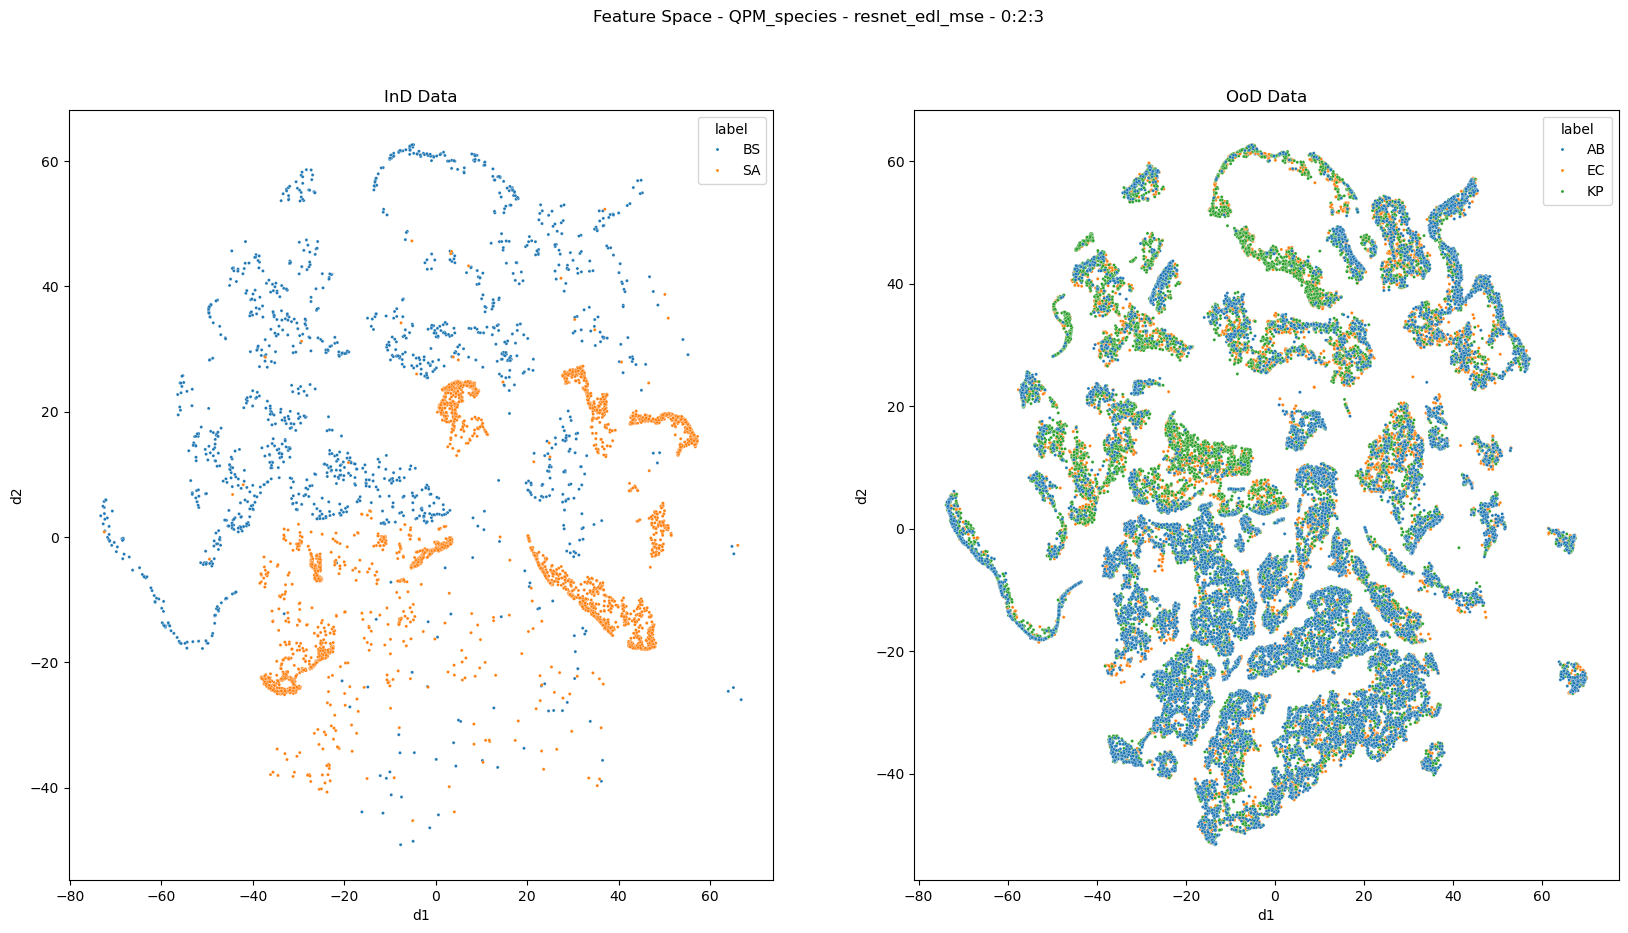

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

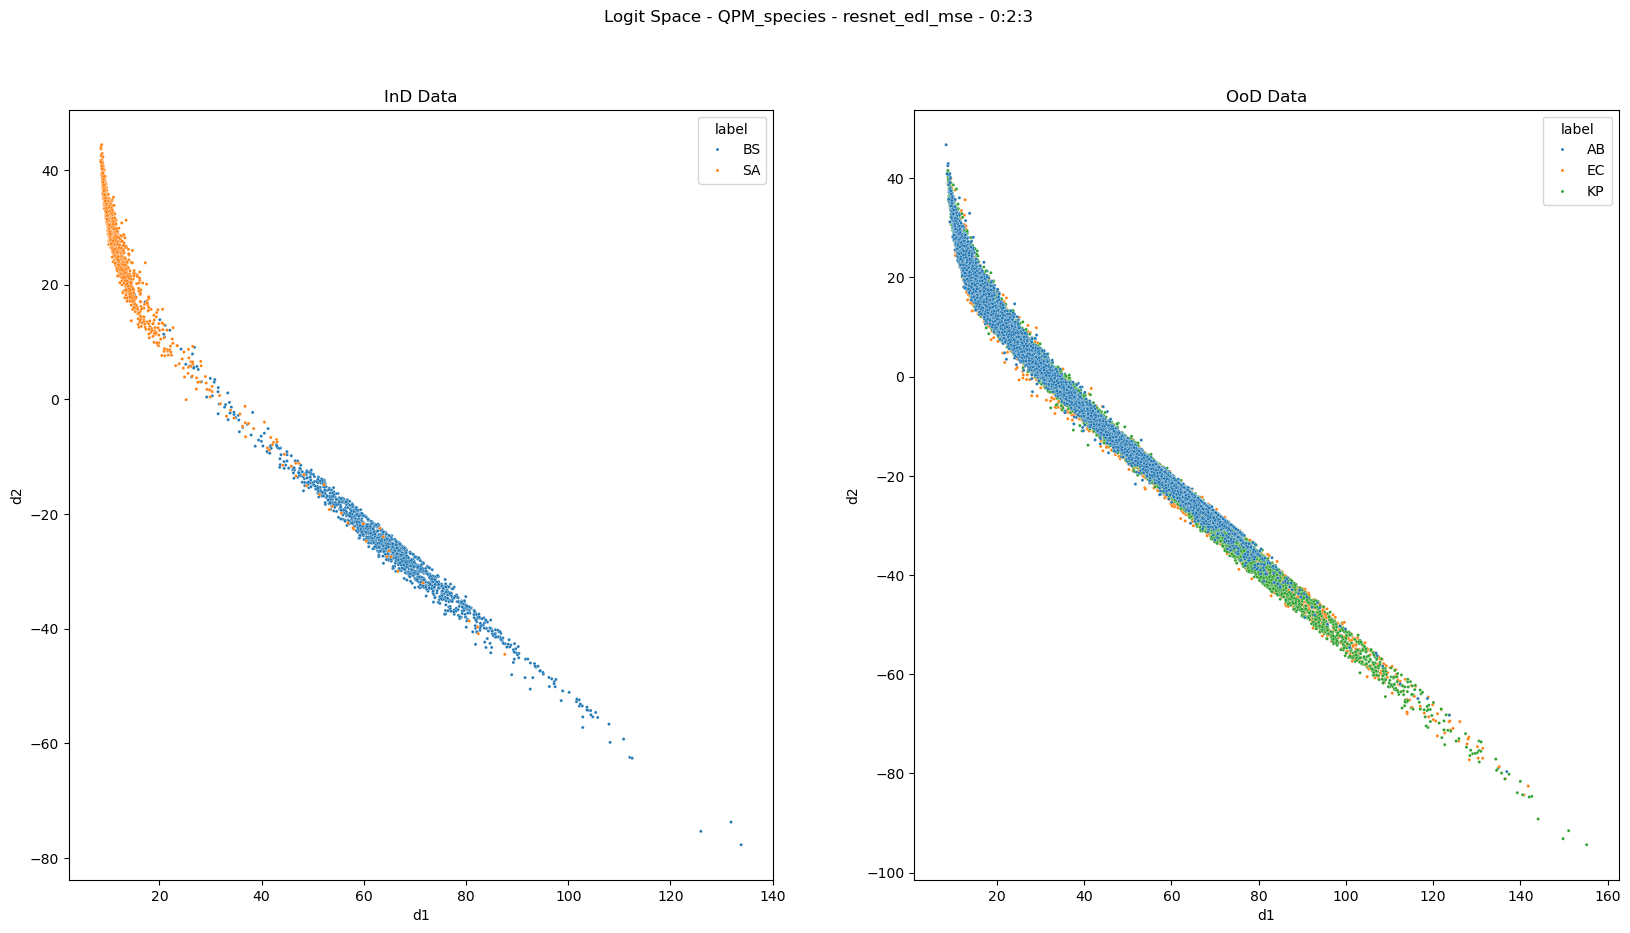

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:05,  1.96s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:04<00:04,  2.11s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:06<00:02,  2.11s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

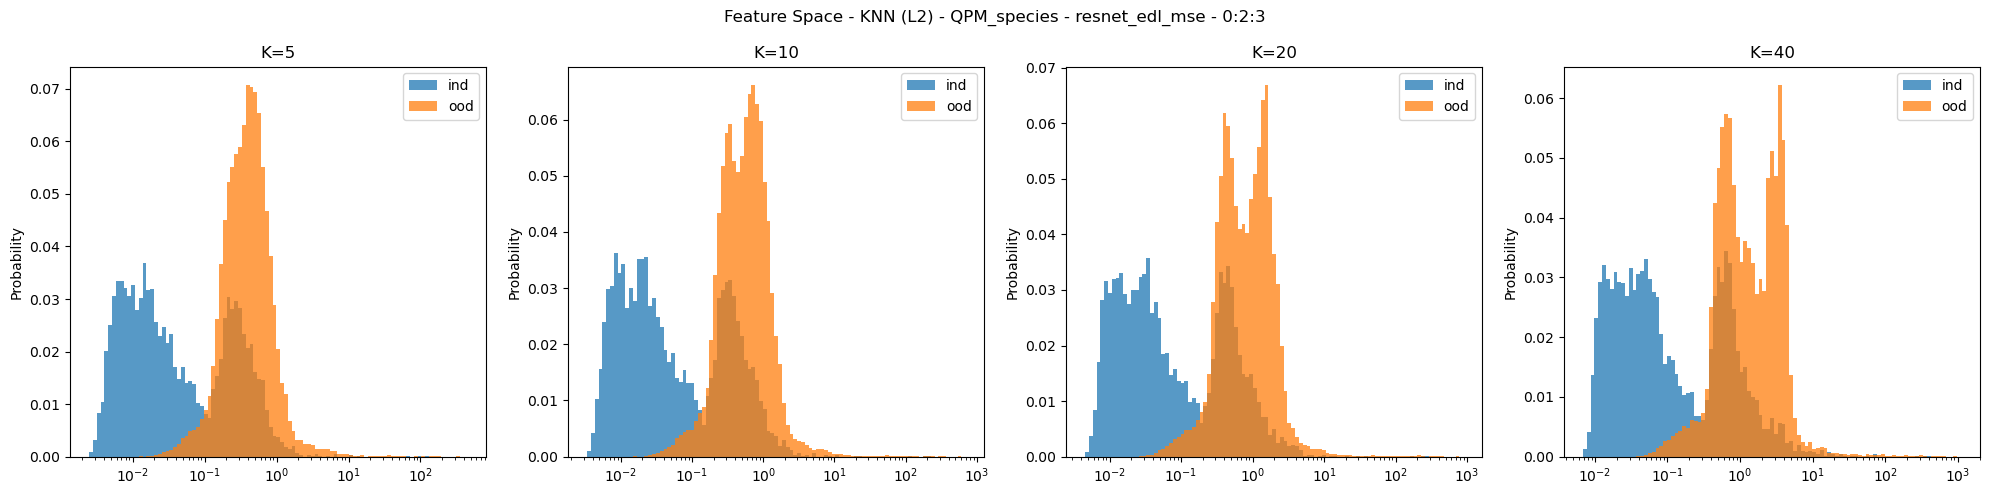

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:05,  1.74s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:03<00:03,  1.74s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:05<00:01,  1.85s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.86s/it]

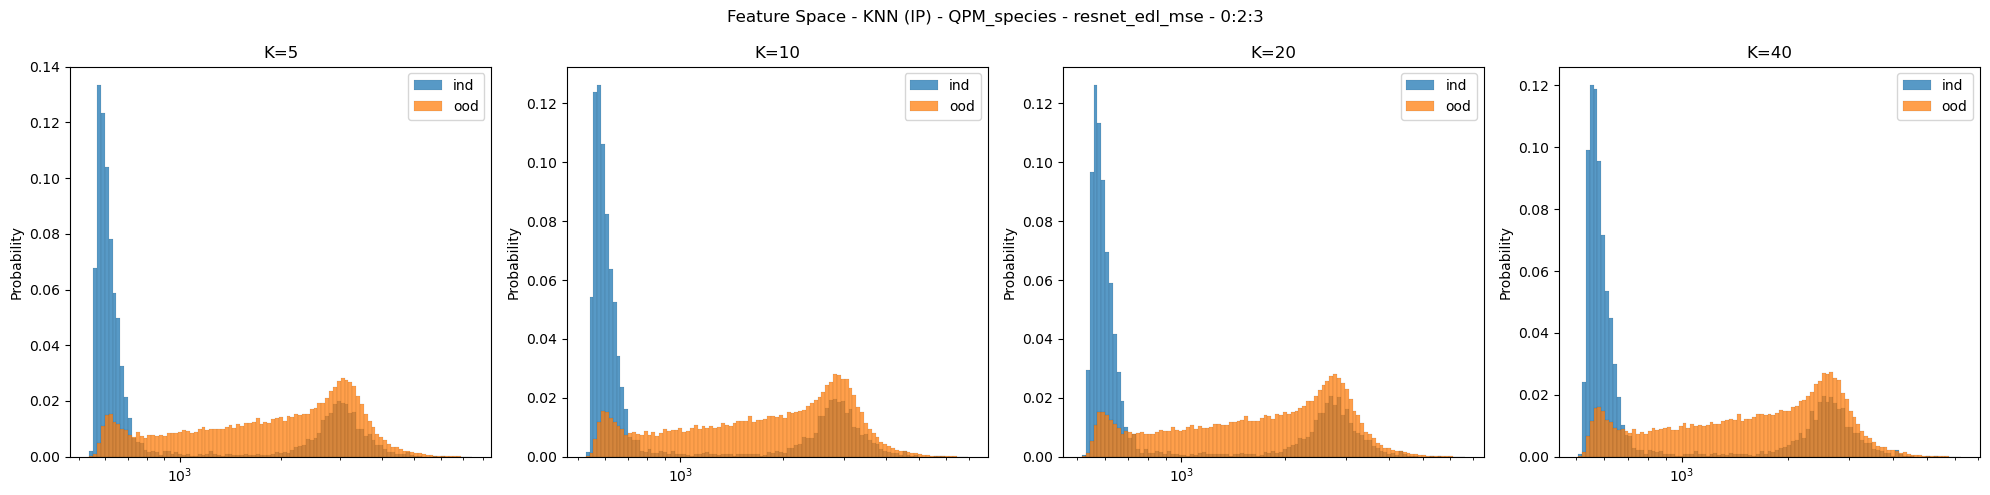

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:01<00:05,  1.74s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:03<00:03,  1.74s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:05<00:01,  1.76s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.85s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]

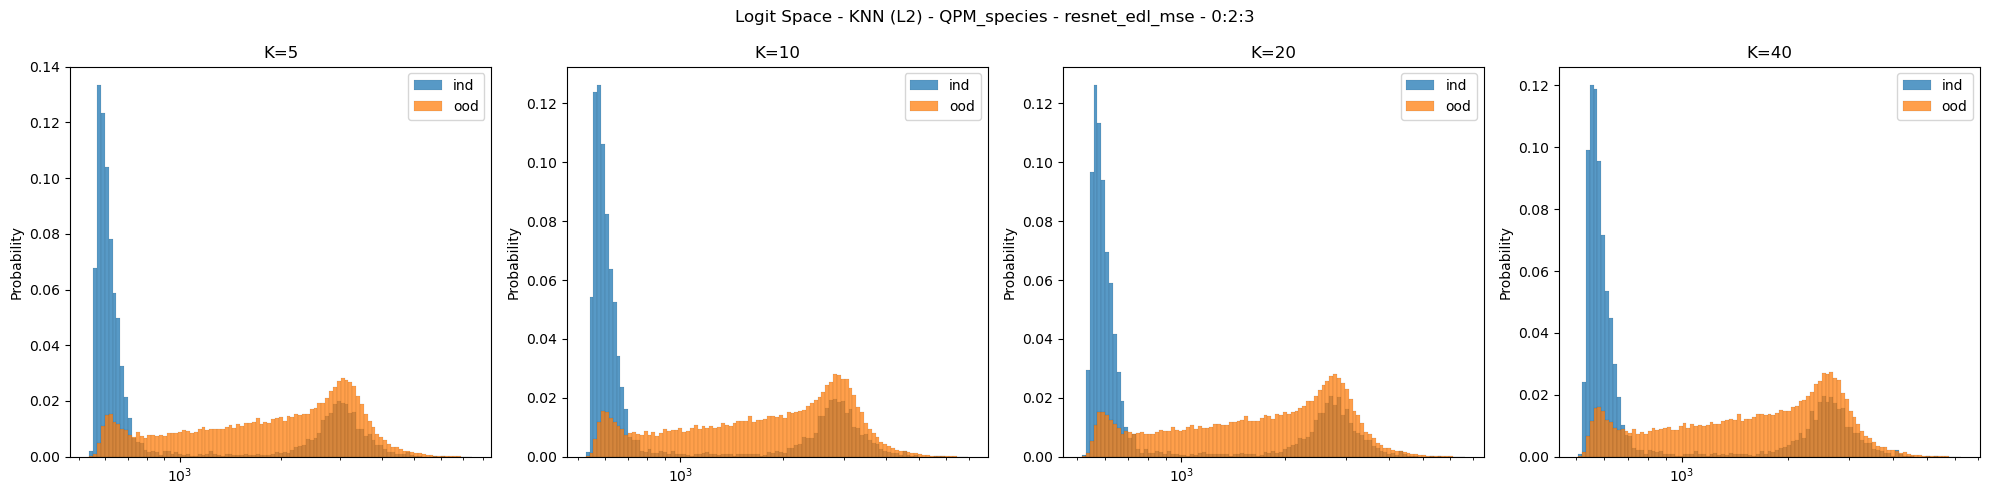

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:02<00:06,  2.01s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:03<00:03,  1.86s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:05<00:01,  1.84s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]

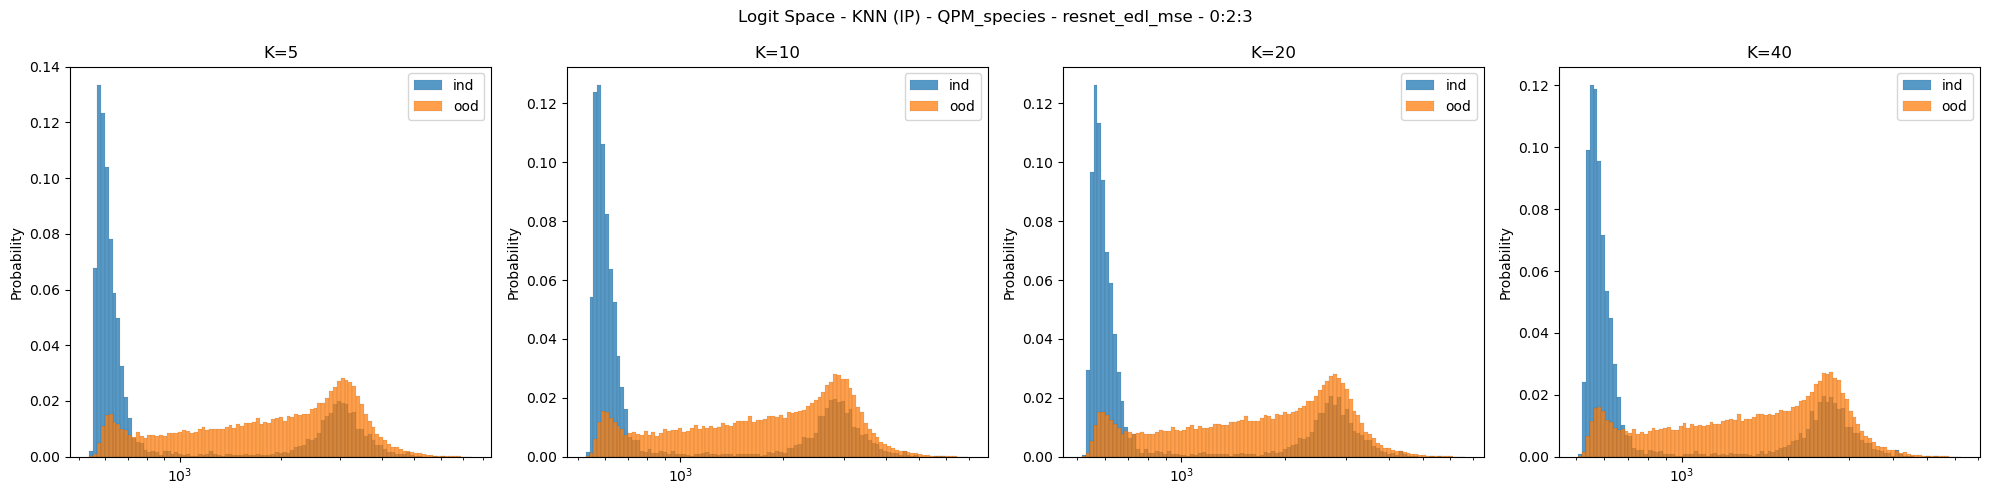

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_3694915/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3694915/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3694915/3659132256.py:6: RuntimeWarning: overflow encountered in exp
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3694915/3659132256.py:6: RuntimeWarning: invalid value encountered in divide
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)


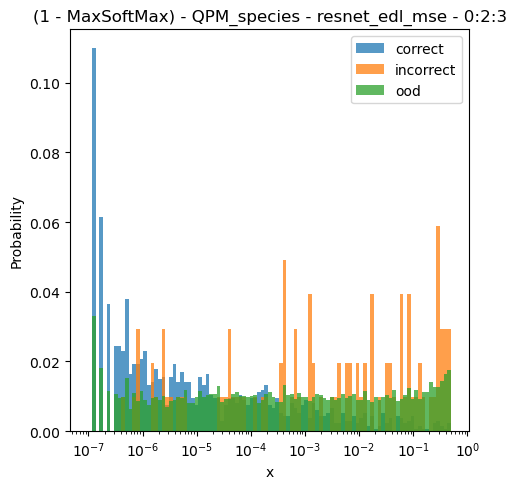

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

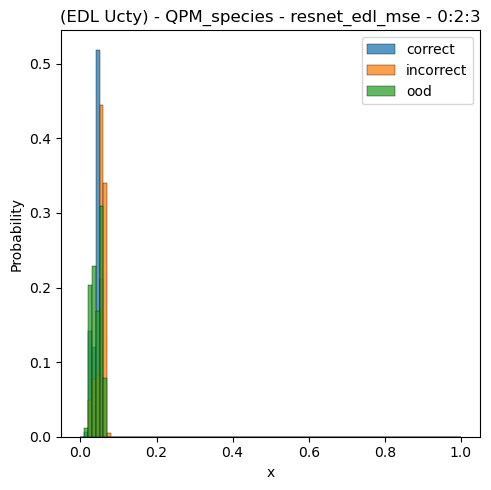

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()